# So 1.0.0 doesn't actually convincingly perform better than 0.2.1 (RF) so I'm seeing if more hidden layers changes anything

In [1]:
import data_science.lendingclub.dataprep_and_modeling.modeling_utils.data_prep_new as data_prep
import dir_constants as dc
from sklearn.externals import joblib
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import time
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
%matplotlib notebook

In [24]:
from fastai.structured import *
from fastai.column_data import *

# DO NOT FORGET TO DROP ISSUE_D AFTER PREPPING

In [2]:
platform = 'lendingclub'
use_cuda = True
dtype = torch.cuda.FloatTensor
save_path = f'{datapath}lendingclub/model_dump'
if not os.path.isdir(save_path):
    os.mkdir(save_path)
store = pd.HDFStore(f'{datapath}{platform}/{platform}.h5')
type_model = 'ctest'

In [3]:
if type_model == 'ctest':
    loan_info = store['ctrain']
    eval_cols = store['ctrain_roi']
    std_dev = loan_info.std()
    to_drop = std_dev[std_dev == 0].index.values
    loan_info.drop(to_drop, axis=1, inplace=True)
elif type_model == 'all_train':
    loan_info = store['all_train']
    eval_cols = store['all_train_roi']    
store.close()

# Until I figure out a good imputation method (e.g. bayes PCA), just drop columns with null still

In [4]:
comp_mean, comp_std = joblib.load(f'{save_path}/mean_stddev_0.2.2_ctest.pkl')

In [5]:
mean_series = loan_info.mean()
std_dev_series = loan_info.std()

In [11]:
train_X = (loan_info - mean_series) / std_dev_series
train_X = train_X.astype(float)
train_y = eval_cols

In [12]:
class TrainDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx,:], self.targets[idx,:]
    
def get_loader(dataset, use_cuda, batch_size=6400, shuffle=True):
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, pin_memory=use_cuda) 

train_dataset = TrainDataset(train_X.values, train_y.values)
train_loader = get_loader(train_dataset, use_cuda)

# Fastai style

# instantiate network

In [14]:
# %%writefile model_dump/nn_1_0_1/net_class.py
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from torch.autograd import Variable
# import numpy as np

# dtype = torch.FloatTensor

# nn_input_dim = 223
# hly1_n = 300
# hly2_n = 400
# hly3_n = 300
# hly4_n = 200
# hly5_n = 100
# hly6_n = 100
# hly7_n = 100
# # hly8_n = 100
# nn_output_dim = 1

# class Net(nn.Module):
    
#     def __init__(self):
#         super(Net, self).__init__()
#         self.hl1 = nn.Linear(nn_input_dim, hly1_n)
#         self.hl2 = nn.Linear(hly1_n, hly2_n)
#         self.hl3 = nn.Linear(hly2_n, hly3_n)
#         self.hl4 = nn.Linear(hly3_n, hly4_n)
#         self.hl5 = nn.Linear(hly4_n, hly5_n)
#         self.hl6 = nn.Linear(hly5_n, hly6_n)
#         self.hl7 = nn.Linear(hly6_n, hly7_n)
# #         self.hl8 = nn.Linear(hly7_n, hly8_n)        
#         self.out = nn.Linear(hly7_n, nn_output_dim)
        
#     def forward(self, x):
#         x = F.leaky_relu(self.hl1(x))
#         x = F.leaky_relu(self.hl2(x))
#         x = F.leaky_relu(self.hl3(x))
#         x = F.leaky_relu(self.hl4(x))
#         x = F.leaky_relu(self.hl5(x))
#         x = F.leaky_relu(self.hl6(x))        
#         x = F.leaky_relu(self.hl7(x))        
# #         x = F.leaky_relu(self.hl8(x))
#         x = self.out(x)
#         return x


    
# def torch_version(df_inputs, net):
#     input = Variable(torch.from_numpy(df_inputs.values)).type(dtype)
#     return np.round(net(input).data.cpu().numpy(),5).ravel()    

In [20]:
nn_input_dim = train_X.shape[1]
hly1_n = 300
hly2_n = 400
hly3_n = 300
hly4_n = 200
hly5_n = 100
hly6_n = 100
hly7_n = 100
# hly8_n = 100
nn_output_dim = 1

class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.hl1 = nn.Linear(nn_input_dim, hly1_n)
        self.hl2 = nn.Linear(hly1_n, hly2_n)
        self.hl3 = nn.Linear(hly2_n, hly3_n)
        self.hl4 = nn.Linear(hly3_n, hly4_n)
        self.hl5 = nn.Linear(hly4_n, hly5_n)
        self.hl6 = nn.Linear(hly5_n, hly6_n)
        self.hl7 = nn.Linear(hly6_n, hly7_n)
#         self.hl8 = nn.Linear(hly7_n, hly8_n)        
        self.out = nn.Linear(hly7_n, nn_output_dim)
        
    def forward(self, x):
        x = F.leaky_relu(self.hl1(x))
        x = F.leaky_relu(self.hl2(x))
        x = F.leaky_relu(self.hl3(x))
        x = F.leaky_relu(self.hl4(x))
        x = F.leaky_relu(self.hl5(x))
        x = F.leaky_relu(self.hl6(x))        
        x = F.leaky_relu(self.hl7(x))        
#         x = F.leaky_relu(self.hl8(x))
        x = self.out(x)
        return x
    
net = Net()

In [21]:
params = list(net.parameters())
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001, weight_decay=0.00135)
# scheduler = torch.optim.lr

In [22]:
if use_cuda:
    net.cuda()
    criterion.cuda()

<IPython.core.display.Javascript object>


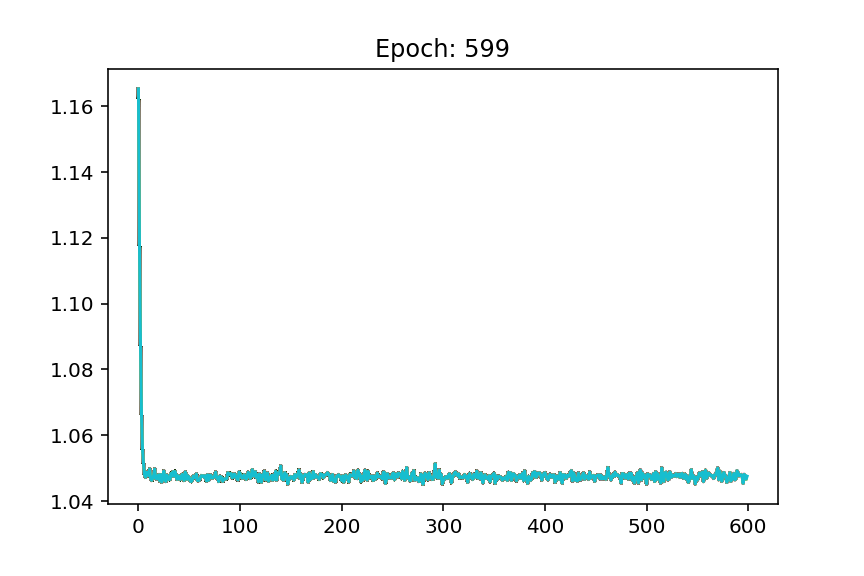

In [23]:
n_epochs = 600
epoch_list = []
loss_list = []

fig = plt.gcf()
fig.show()
fig.canvas.draw()

for epoch in range(n_epochs):
    running_loss = 0
    for i, data in enumerate(train_loader):
        inputs, targets = data
        # wrap in Variable
        inputs, targets = Variable(inputs.cuda()).type(dtype), Variable(targets.cuda()).type(dtype)

        # in your training loop:
        optimizer.zero_grad()   # zero the gradient buffers
        
        output = net(inputs)
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.data[0]
    
    try:
        last_loss = loss_list[-1]
    except:
        last_loss = 9999999999999
    if running_loss > (2*last_loss):
        pass
    else:
        epoch_list.append(epoch)
        loss_list.append(running_loss)
    if epoch+1 % 100 == 0:
        # drop learning rate at 250 epoch
        optimizer.param_groups[0]['lr'] *= .97
    if epoch % 1 == 0:
        plt.plot(epoch_list, loss_list)
        plt.title("Epoch: {0}".format(epoch))
        fig.canvas.draw()
    if (epoch >= 99) & ((epoch+1) % 20 == 0):
        torch.save(net.state_dict(), save_path+'1.0.1_e{0}'.format(epoch+1))

# get the weights and biases of the nn into np since at this size np is faster (correction, pytorch was faster)

In [ ]:
# np_hl1_weight = net.hl1.weight.data.numpy()
# np_hl1_bias = net.hl1.bias.data.numpy()
# np_hl2_weight = net.hl2.weight.data.numpy()
# np_hl2_bias = net.hl2.bias.data.numpy()
# np_out_weight = net.out.weight.data.numpy()
# np_out_bias = net.out.bias.data.numpy()

# check that they output the same and speedtest (pytorch was faster)

In [ ]:
# def np_version(df_inputs):
#     np_hl1_z = df_inputs.dot(np_hl1_weight.T) + np_hl1_bias
#     np_hl1_a = np.maximum(.01*np_hl1_z, np_hl1_z)
#     np_hl2_z = np_hl1_a.dot(np_hl2_weight.T) + np_hl2_bias
#     np_hl2_a = np.maximum(.01*np_hl2_z, np_hl2_z)
#     np_out = np_hl2_a.dot(np_out_weight.T) + np_out_bias
#     return np_out

class FeedDataset(Dataset):
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data.iloc[idx,:].values

def torch_version(df_inputs, net):
    feed_dataset = FeedDataset(df_inputs)
    feed_loader = get_loader(feed_dataset, batch_size=6400, shuffle=False, use_cuda = True)
    all_results = []
    for i, data in enumerate(feed_loader):
        # wrap in Variable
        inputs = data
        inputs = Variable(inputs.cuda()).type(dtype)
#         inputs = Variable(inputs.cuda()).type(dtype)
        outputs = np.round(net(inputs).data.cpu().numpy(),5).ravel().tolist()
        all_results += outputs
    return all_results

In [ ]:
#%timeit np_version(standardized)

In [ ]:
# %timeit torch_version(train_X, net)

# Examine performance on test set

In [ ]:
store.open()
test = store['test_filtered_columns']
train = store['train_filtered_columns']
loan_npv_rois = store['loan_npv_rois']
default_series = test['target_strict']
results = store['results']
store.close()

In [ ]:
train_X, train_y = data_prep.process_data_test(train)
train_y = train_y['npv_roi_10'].values
test_X, test_y = data_prep.process_data_test(test)
test_y = test_y['npv_roi_10'].values
# regr = joblib.load('model_dump/model_0.2.1.pkl')
regr_version = '1.0.1'
test_yhat = torch_version(test_X, net)
train_yhat = torch_version(train_X, net)

In [ ]:
test_mse = mean_squared_error(test_yhat,test_y)
train_mse = mean_squared_error(train_yhat,train_y)

In [ ]:
test_mse

In [ ]:
train_mse

In [ ]:
def eval_models_net(trials, port_size, available_loans, net, regr_version, test, loan_npv_rois,
                default_series):
    results = {}
    pct_default = {}
    test_copy = test.copy()
    for trial in tqdm_notebook(np.arange(trials)):
        loan_ids = np.random.choice(
            test_copy.index.values, available_loans, replace=False)
        loans_to_pick_from = test_copy.loc[loan_ids, :]
        scores = torch_version(loans_to_pick_from, net)
        scores_series = pd.Series(dict(zip(loan_ids, scores)))
        scores_series.sort_values(ascending=False, inplace=True)
        picks = scores_series[:900].index.values
        results[trial] = loan_npv_rois.loc[picks, :].mean().to_dict()
        pct_default[trial] = (default_series.loc[picks].sum()) / port_size
    pct_default_series = pd.Series(pct_default)
    results_df = pd.DataFrame(results).T
    results_df['pct_def'] = pct_default_series
    return results_df

In [ ]:
# as per done with baseline models, say 3000 loans available
# , pick 900 of them
trials = 20000
port_size = 900
available_loans = 3000
model_results = eval_models_net(trials, port_size, available_loans, net, regr_version, test_X, loan_npv_rois, default_series)

In [ ]:
multi_index = []
for col in model_results.columns.values:
    multi_index.append((str(col),regr_version))
append_results = model_results.copy()
append_results.columns = pd.MultiIndex.from_tuples(multi_index, names = ['discount_rate', 'model'])    

In [ ]:
multi_index_results = []
for col in results.columns.values:
    multi_index_results.append((str(col[0]), col[1]))
results.columns = pd.MultiIndex.from_tuples(multi_index_results, names = ['discount_rate', 'model'])    

In [ ]:
full_results = results.join(append_results)
full_results.sort_index(axis=1, inplace=True)

In [ ]:
full_results.describe()

In [ ]:
store.open()
store['results'] = full_results
model_info = store['model_info']
store.close()

# Making model info and saving it

In [ ]:
# dump the model
# joblib.dump(regr, 'model_dump/model_0.2.1.pkl')
joblib.dump((mean_series, std_dev_series), 'model_dump/mean_stddev.pkl')

In [ ]:
test_mse

In [ ]:
train_mse

In [ ]:
now = time.strftime("%Y_%m_%d_%Hh_%Mm_%Ss")
# info to stick in detailed dataframe describing each model
model_info_dict = {'model_version': regr_version,
              'target': 'npv_roi_10',
              'weights': 'None',
              'algo_model': 'feedforward NN',
              'hyperparams': "nn_input_dim = 223, hly1_n = 300, hly2_n = 400, hly3_n = 300, hly4_n = 200, hly5_n = 100, hly6_n = 100, hly7_n = 100, nn_output_dim = 1, criterion = nn.MSELoss(),optimizer = optim.Adam(net.parameters(), lr=0.0001, weight_decay=0.00135),     if epoch+1 % 100 == 0: optimizer.param_groups[0]['lr'] *= .97",
              'cost_func': 'criterion = nn.MSELoss(),',
              'useful_notes': 'test_mse: 0.0642635, train_mse: 0.061784, epoch_600',
              'date': now}

model_info_df = pd.DataFrame(model_info_dict, index = [regr_version])

In [ ]:
model_info.ix[regr_version,:] = model_info_df.values

In [ ]:
model_info.sort_index(inplace=True)

In [ ]:
model_info

In [ ]:
store.open()
store.append(
            'model_info',
            model_info,
            data_columns=True,
            index=True,
            append=False,
)
store.close()

# Examine scores distributions

In [ ]:
train_preds = pd.Series(train_yhat)
test_preds = pd.Series(test_yhat)

In [ ]:
train_preds.hist(bins=50)

In [ ]:
test_preds.hist(bins=50)

In [ ]:
train_preds.describe()

In [ ]:
test_preds.describe()

In [ ]:
train_preds.value_counts()

In [ ]:
test_preds.value_counts()

In [ ]:
# try:
#     results = results.join(append_results)
# except ValueError:
#     results.loc[:, (slice(None), slice('1.0.0','1.0.0'))] = append_results
# results.sort_index(axis=1, inplace = True)

In [ ]:
columns = loan_info.columns.values
# checking dtypes to see which columns need one hotting, and which need null or not
to_one_hot = []
to_null_or_not = []
do_nothing = []
for col in columns:
    if loan_info[col].dtypes == np.dtype('O'):
#         print(col, loan_info[col].isnull().value_counts(dropna=False).to_dict())
        to_one_hot.append(col)
    elif len(loan_info[col].isnull().value_counts(dropna=False)) > 1:
#         print(col, loan_info[col].isnull().value_counts(dropna=False).to_dict())
        to_null_or_not.append(col)
    else:
#         print(col, loan_info[col].isnull().value_counts(dropna=False).to_dict())
        do_nothing.append(col)